In [1]:
import napari
import napari_stress
import tqdm

from napari_stress import approximation, measurements

from napari.types import SurfaceData
from napari_stress import measurements
import matplotlib.pyplot as plt
from pygeodesic import geodesic
import pygeodesic
import numpy as np

import napari_process_points_and_surfaces as nppas
from itertools import product, combinations, permutations

## Create sample data

In [2]:
# Get some sample data
pointcloud = napari_stress.get_droplet_point_cloud()[0]

In [3]:
max_degree = 5
fitted_points = napari_stress.fit_spherical_harmonics(pointcloud[0], max_degree=max_degree)

In [4]:
coefficients = fitted_points[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=250, use_minimal_point_set=False)
manifold = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

In [5]:
surface = nppas.surface_from_point_cloud_ball_pivoting(quadrature_points)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Demonstrate geodesics

In [6]:
viewer = napari.Viewer(ndisplay=3)

Assistant skips harvesting pyclesperanto as it's not installed.


In [7]:
viewer.add_points(quadrature_points, size=0.1, face_color='orange')
viewer.add_surface(surface)

<Surface layer 'surface' at 0x2bbddbe2ca0>

In [8]:
geoalg = geodesic.PyGeodesicAlgorithmExact(surface[0], surface[1])

In [9]:
distance, path = geoalg.geodesicDistance(0, 150)
edges = np.diff(path, axis=0)
points = path[:-1]
vectors = np.stack([points, edges]).transpose((1,0,2))

In [10]:
viewer.add_vectors(vectors, edge_width=0.1)

<Vectors layer 'vectors' at 0x2bbdf06ba90>

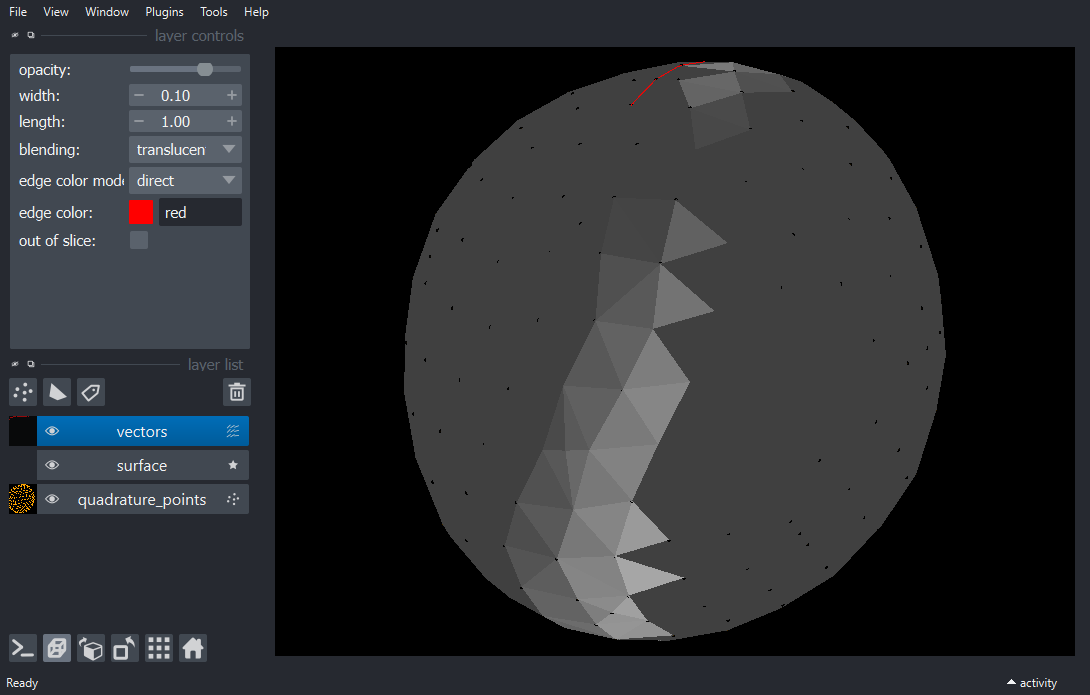

In [11]:
napari.utils.nbscreenshot(viewer)

## Measure stresses

In [12]:
gamma = 26.0

### Ellipsoid fit

First, we fit an ellipsoid to the pointcloud. The ellipsoid represents the tissue-scale stresses.

In [13]:
fitted_ellipsoid = approximation.least_squares_ellipsoid(pointcloud[0])
fitted_ellipse_points = approximation.expand_points_on_ellipse(fitted_ellipsoid, pointcloud[0])

In [14]:
curvature_on_ellipsoid = measurements.curvature_on_ellipsoid(fitted_ellipsoid, fitted_ellipse_points)
H_ellipsoid_major_medial_minor = curvature_on_ellipsoid[1]['metadata']['H_ellipsoid_major_medial_minor']

In [15]:
fitted_ellipse_points_spherical_harmoniocs = napari_stress.fit_spherical_harmonics(fitted_ellipse_points, max_degree=max_degree)
coefficients = fitted_ellipse_points_spherical_harmoniocs[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=150, use_minimal_point_set=False)
manifold_ellipsoid = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

In [16]:
_, _, H0_ellipsoid = measurements.calculate_mean_curvature_on_manifold(manifold_ellipsoid)

quadrature_points_on_ellipsoid = approximation.expand_points_on_ellipse(fitted_ellipsoid, quadrature_points)
mean_curvature_ellipsoid = measurements.curvature_on_ellipsoid(fitted_ellipsoid, quadrature_points_on_ellipsoid)[1]['features']['mean_curvature']

### Spherical harmonics expansion

We now do a spherical harmonics expansion of the raw pointcloud. This also captures the higher orders of curvature on the surface of the droplet.

In [17]:
fitted_points = napari_stress.fit_spherical_harmonics(pointcloud[0], max_degree=max_degree)
fitted_points_layer = viewer.add_points(fitted_points[0], **fitted_points[1], name='spherical harmonics expansion')

In [18]:
coefficients = fitted_points[1]['metadata']['spherical_harmonics_coefficients']
quadrature_points, lebedev_fit = napari_stress.lebedev_quadrature(coefficients=coefficients, number_of_quadrature_points=150, use_minimal_point_set=False)
manifold_droplet = napari_stress.create_manifold(quadrature_points, lebedev_fit=lebedev_fit, max_degree=max_degree)

In [19]:
mean_curvature_spherical_harmonics, _, H0_surface_integral_spherical_harmonics = measurements.calculate_mean_curvature_on_manifold(manifold_droplet)

In [20]:
stress, stress_tissue, stress_droplet = measurements.anisotropic_stress(mean_curvature_spherical_harmonics, H0_surface_integral_spherical_harmonics,
                                                                        mean_curvature_ellipsoid, H0_ellipsoid,
                                                                        gamma=gamma)

## geodesics analysis

In [21]:
viewer2 = napari.Viewer()

In [22]:
surface = nppas.surface_from_point_cloud_ball_pivoting(quadrature_points)
surface = list(nppas.fill_holes(surface))

In [23]:
surface_total = surface + [stress]
surface_tissue = surface + [stress_tissue]
surface_droplet = surface + [stress_droplet]

In [ ]:
viewer2.add_surface(surface_total, shading='none', colormap = 'twilight')
viewer2.add_surface(surface_tissue, shading='none', colormap = 'twilight')
viewer2.add_surface(surface_droplet, shading='none', colormap = 'twilight')
viewer2.add_points(quadrature_points, size=0.5)

<Points layer 'quadrature_points' at 0x2bbe4c94af0>

In [30]:
result = measurements.geodesic_analysis(surface_total, surface_tissue, surface_droplet)

Calculating geodesic distances: 100%|██████████████████████████████████████████| 10585/10585 [00:06<00:00, 1674.69it/s]


In [ ]:
maxima = surface[0][np.argwhere(result['min_max_distances']['local_maxima_and_minima'] == 1)].squeeze()
minima = surface[0][np.argwhere(result['min_max_distances']['local_maxima_and_minima'] == -1)].squeeze()
viewer2.add_points(maxima, face_color='cyan', size=1.5)
viewer2.add_points(minima, face_color='orange', size=1.5)

In [35]:
result['min_max_distances'][1]

,min_max_pair_distances,min_max_pair_anisotropies
0,17.921399,1.557215
1,31.244292,1.789089
2,26.443318,0.974676
3,16.863573,1.041113
4,12.651446,1.371943
5,35.306854,1.362483
6,13.892705,1.594356
7,16.360795,0.779944
8,28.459377,0.846380
9,22.558149,1.177211
